In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms

In [2]:
IMG_WIDTH, IMG_HEIGHT = 96, 96
N_CHANNELS = 3  # RGB
BATCH_SIZE = 20
LEARNING_RATE = 0.01
N_EPOCHS = 20


In [3]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        n_input = N_CHANNELS * IMG_HEIGHT * IMG_WIDTH  # 3*96*96 = 27648
        hidden_1 = 2048
        hidden_2 = 512
        hidden_3 = 128
        n_output = 10
        
        self.fc1 = nn.Linear(n_input, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, hidden_3)
        self.fc4 = nn.Linear(hidden_3, n_output)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1,  N_CHANNELS * IMG_HEIGHT * IMG_WIDTH)
        x = F.relu(self.fc1(x)) 
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x


In [5]:
# total weights in fully connected layers:
27648*2048 + 2048*512 + 512*128 + 128*10

57738496

In [6]:
transf = transforms.ToTensor()
train_folder = datasets.ImageFolder(root="../dataset/train/", 
                                    transform=transf)
test_folder = datasets.ImageFolder(root="../dataset/test/", 
                                   transform=transf)
train_folder

Dataset ImageFolder
    Number of datapoints: 10000
    Root location: ../dataset/train/
    StandardTransform
Transform: ToTensor()

In [7]:
train_loader = torch.utils.data.DataLoader(train_folder, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_folder, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)

#### Training

In [8]:
model = Net()
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
    
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

model.train() # put model in training mode

losses = []

for epoch in range(N_EPOCHS):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
                
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    losses.append(train_loss)
    print(f"Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f}")

Epoch: 1 	Training Loss: 2.096524
Epoch: 2 	Training Loss: 1.915944
Epoch: 3 	Training Loss: 1.844009
Epoch: 4 	Training Loss: 1.786746
Epoch: 5 	Training Loss: 1.735497
Epoch: 6 	Training Loss: 1.707588
Epoch: 7 	Training Loss: 1.672071
Epoch: 8 	Training Loss: 1.646053
Epoch: 9 	Training Loss: 1.614752
Epoch: 10 	Training Loss: 1.586728
Epoch: 11 	Training Loss: 1.564453
Epoch: 12 	Training Loss: 1.540650
Epoch: 13 	Training Loss: 1.517706
Epoch: 14 	Training Loss: 1.493467
Epoch: 15 	Training Loss: 1.469637
Epoch: 16 	Training Loss: 1.451112
Epoch: 17 	Training Loss: 1.430727
Epoch: 18 	Training Loss: 1.411103
Epoch: 19 	Training Loss: 1.380069
Epoch: 20 	Training Loss: 1.362028


#### Test

In [9]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
            
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(BATCH_SIZE):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print(f"Test Loss: {test_loss:.6f}\n")

for i in range(len(test_folder.classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            test_folder.classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.781322

Test Accuracy of airplane: 66% (199/300)
Test Accuracy of  bird: 19% (57/300)
Test Accuracy of   car: 56% (169/300)
Test Accuracy of   cat: 13% (39/300)
Test Accuracy of  deer: 22% (66/300)
Test Accuracy of   dog: 16% (48/300)
Test Accuracy of horse: 87% (261/300)
Test Accuracy of monkey: 13% (41/300)
Test Accuracy of  ship: 44% (133/300)
Test Accuracy of truck: 36% (109/300)

Test Accuracy (Overall): 37% (1122/3000)


In [11]:
model

Net(
  (fc1): Linear(in_features=27648, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

#### Visualize Sample Test Results

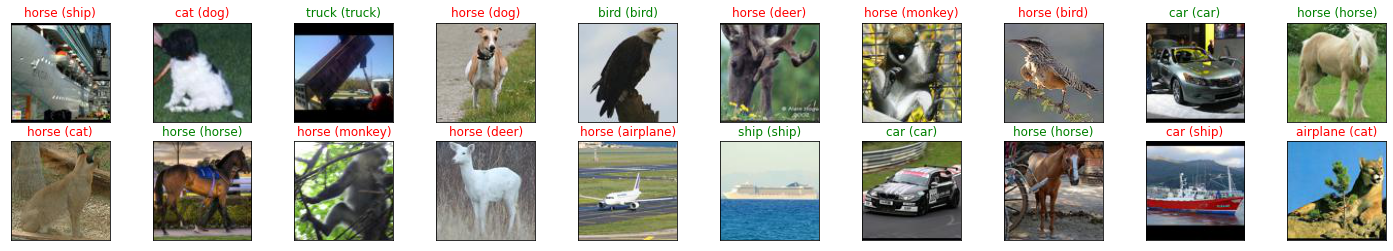

In [20]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

classes = test_folder.classes

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(BATCH_SIZE):
    ax = fig.add_subplot(2, int(BATCH_SIZE/2), idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx].permute(1, 2, 0))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

This Multi Layer Perceptron is just there to have some baseline model, even with low accuracy.

Since MLP has only fully-connected layers, there is no surprise that it:
* can't extract spatial features of image
* doesn't have scale/rotation/translation invariance, unlike CNNs.

Let's consider some incorrectly classified images from above's sample:
* _airplane_ instead of _cat_ (bottom-right): possible reason -- high percentage of blue background, which is often present on airplane pictures;
* _horse_ instead of _airplane_ (bottom, 5th image): potentially because of a green field background.

We definitely need to train a Convolutional Neuron Network, to be able to extract common features from spatially-connected regions, in order to have a vector of meaningful features. Then we'll be able to feed this feature vector to some fully-connected layers at the end of CNN.